# Libraries and Settings

In [1]:
##########==========##########==========##########==========##########==========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as ct
import datetime as dt
import fastkml as kml
from shapely.geometry import MultiLineString, LineString
from matplotlib.colors import hsv_to_rgb
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
from geopy.distance import distance as earth_distance

def hsv(h, s, v):
    h = np.array(h)
    s = np.array(s)
    v = np.array(v)
    y = np.column_stack((h, s, v))
    y = hsv_to_rgb(y)
    return tuple(y[0])

## general purpose visualization settings
set_font = {'L':42, 'M':28, 'S': 14}
set_color = {
       'Foreground': hsv(0, 0, 0), 'Background': hsv(7/12, 0.05, 1.0),
    
    'Coast':  hsv(7/12, 0.50, 0.7),
    'Border': hsv(1/12, 0.05, 0.8),
    'Land':   hsv(1/12, 0.05, 1.0),
    
    
    'Photo':   hsv(1/12, 0.8, 0.3),
    'Visit':   hsv(1/12, 0.8, 0.5),
    'Unvisit': hsv(1/12, 0.8, 0.8)

}



## general purpose cartography data
map_projection = ct.crs.LambertConformal(
                            central_longitude = (-124.73 - 66.95) / 2,
                            central_latitude = (25.12 + 49.38) / 2,
                            standard_parallels = (25.12, 49.38)
                        )
map_extent = [-124.73 + 5, -66.95 - 5, 25.12 - 3.25, 49.38 + 3.25]

## function to express time stamps
def time_check(s = 'Alfa'):
    print('Time Check: Point ' + s)
    print(dt.datetime.now())
    
## create test objects
test_failures = []
manual_check_list = dict()

# Read in data

### read in docx files

In [2]:
## read in text blurbs
def import_texts(address = 'A_Input/paragraph_text'):
    from os import listdir
    from docx import Document
    x = listdir(address)
    y = dict()
    extract_text = lambda x: x.text
    for i in x:
        j = Document(address + '/' + i).paragraphs
        j = map(extract_text, j)
        y[i.replace('.docx', '')] = list(j)
        
    return y

panel_paragraph = import_texts()

### test docx files

In [3]:
## test text blurbs
def test_texts(tx = panel_paragraph.copy()):
    
    full_pass = True
    
    ## Does the explanation object instantiate the right class? (Mandatory pass)
    assert isinstance(tx, dict)
    
    ## Is there an explanation for each panel?
    all_panels = set(['travels', 'explanation', 'routes', 'progress', 'opportunity', 'legend_plus'])
    if all_panels != set(tx.keys()):
        print("WARNING (test_texts) - Some explanatory texts are missing")
        full_pass = False
        
    ## Will explanations fit in the allotted space?
    right_size = {'explanation':600, 'travels':300, 'progress':150,
        'opportunity':75, 'routes':75, 'legend_plus':75}
    right_size = [right_size[i] - sum(map(len, tx[i])) for i in tx.keys()]
    if min(right_size) < 0:
        print('WARNING (test_texts) - Some explanatory texts exceed character maximum')
        full_pass = False
              
    ## Does the import process mangle text?
    test_phrase = 'THIS IS PLACEHOLDER TEXT'
    actual_ending = tx['explanation'][len(tx['explanation']) - 1]
    if test_phrase != actual_ending[-len(test_phrase):]:
        print('WARNING (test_texts) - Final sentence of sample explanation doesn\'t match test phrase')
        full_pass = False
        
    ## add to warning summary if needed
    if not full_pass:
        test_failures.append('test_texts')
    
test_texts()

WARNING (test_texts) - Some explanatory texts are missing
WARNING (test_texts) - Some explanatory texts exceed character maximum
WARNING (test_texts) - Final sentence of sample explanation doesn't match test phrase


### read in xlsx files

In [4]:
## read in excel files (testing waived, since this is well-tested, pre-packaged code)
city_list = pd.read_excel('A_Input/city_list.xlsx', sheet_name = 'Cities')
route_list = pd.read_excel('A_Input/city_list.xlsx', sheet_name = 'Routes',
    usecols = ['route', 'pre_travel', 'drive_mileage', 'trip_days',
               'best_temp_1', 'best_temp_2', 'states_etc'])

### read in kml files

In [5]:
## read in kml files
def read_kmls(address):
    read_connection = open(address, 'rt', encoding = 'utf-8')
    read_iter = read_connection.read().encode('utf-8')
    kml_data = kml.KML()
    kml_data.from_string(read_iter)
    read_connection.close()
    return kml_data

def process_kmls(kml_obj):

    ## extract route names
    get_name_attr = lambda a: a.name
    def extract_names(x):
        if len(list(x.features())) > 1:
            y = list(x.features())
            y = map(get_name_attr, y)
            return list(y)
        else:
            return extract_names(list(x.features())[0])

    geo_names = extract_names(kml_obj)
        
    ## extract route line strings
    get_geometry_attr = lambda a: a.geometry
    def extract_linestrings(x):
        if isinstance(x, kml.Placemark):
            return x.geometry
        else:
            return map(extract_linestrings, x.features())
            
    line_strings = extract_linestrings(kml_obj)
    
    ## extract linestrings for superfluous nesting
    def unnest_map(x):
        x = list(x)
        if len(x) == 1:
            return unnest_map(x[0])
        else:
            return list(map(list, x))
    line_strings = unnest_map(line_strings)
    
    ## merge linestrings that are part of the same route
    line_strings = map(MultiLineString, line_strings)
    
    ## package names and routes
    y = dict()
    for i in range(len(geo_names)):
        y[geo_names[i]] = next(line_strings)
    return y

## execute
routes  = read_kmls('A_Input/Wishlist.kml')
routes = process_kmls(routes)

travels = read_kmls('A_Input/Travels.kml' )
travels = process_kmls(travels)

### test kml code

In [6]:
## declare helper function to extract the names of folders
def extract_folder_names(address):
    kml_conn = open(address)
    folder_names = []
    current_line_number, grab_next = 0, False
    
    while True:
        current_line = kml_conn.readline()
        
        if grab_next:
            current_line = current_line.strip().replace('<name>', '')
            folder_names.append(current_line.replace('</name>', ''))
            grab_next = False
            
        if len(current_line) == 0:
            break
            
        current_line_number += 1
        
        if current_line.find('<Folder>') != -1:
            grab_next = True
            
    return folder_names[1:]

## 
def test_kmls(addresses = ['A_Input/Wishlist.kml', 'A_Input/Travels.kml'],
              files = [routes.copy(), travels.copy()], rl = route_list.copy()):
    
    full_pass = True
    
    ## Do the recovered routes match the folder <name> tags in the original kml text?
    test_folder_names = [set(extract_folder_names(i)) for i in addresses]
    actual_folder_names = [set(i.keys()) for i in files]
    
    if len(test_folder_names) != len(actual_folder_names):
        print("WARNING (test_kmls) - The number of name sets to test is inconsistent")
        full_pass = False
    else:
        for i in range(len(test_folder_names)):
            if test_folder_names[i] != actual_folder_names[i]:
                print("WARNING (test_kmls) - <name> tags do not match route/travel names")
                full_pass = False 
                
    ## Are the route LineString lengths proportional to estimated distance?
    route_length = files[0]
    for i in route_length.keys():
        route_length[i] = round(route_length[i].length, 6)
    route_length = pd.Series(route_length).to_frame()
    route_length.columns = ['discrepancy']
    route_length.index.set_names('route')
    route_length.reset_index()
    rl = rl.join(route_length, on = 'route')
    rl.discrepancy = rl.discrepancy * np.mean(rl.drive_mileage/rl.discrepancy)
    rl.discrepancy = np.round(rl.drive_mileage - rl.discrepancy, 0)
    if max(abs(rl.discrepancy)) >= 300:
        print('WARNING (test_kmls) - route mileage and LineString length do not match:')
        print(rl[abs(rl.discrepancy) >= 300][['route', 'drive_mileage', 'discrepancy']])
        full_pass = False
    
    ## add to warning summary if needed
    if not full_pass:
        test_failures.append('test_kmls')

x = test_kmls()

# Basic Dashboard Architecture

### Style: Define custom style elements for the visualization

In [7]:
## computations
def define_style():
    pass
## test
def test_style():
    pass

### Layout: Make the layout underlying the visualization

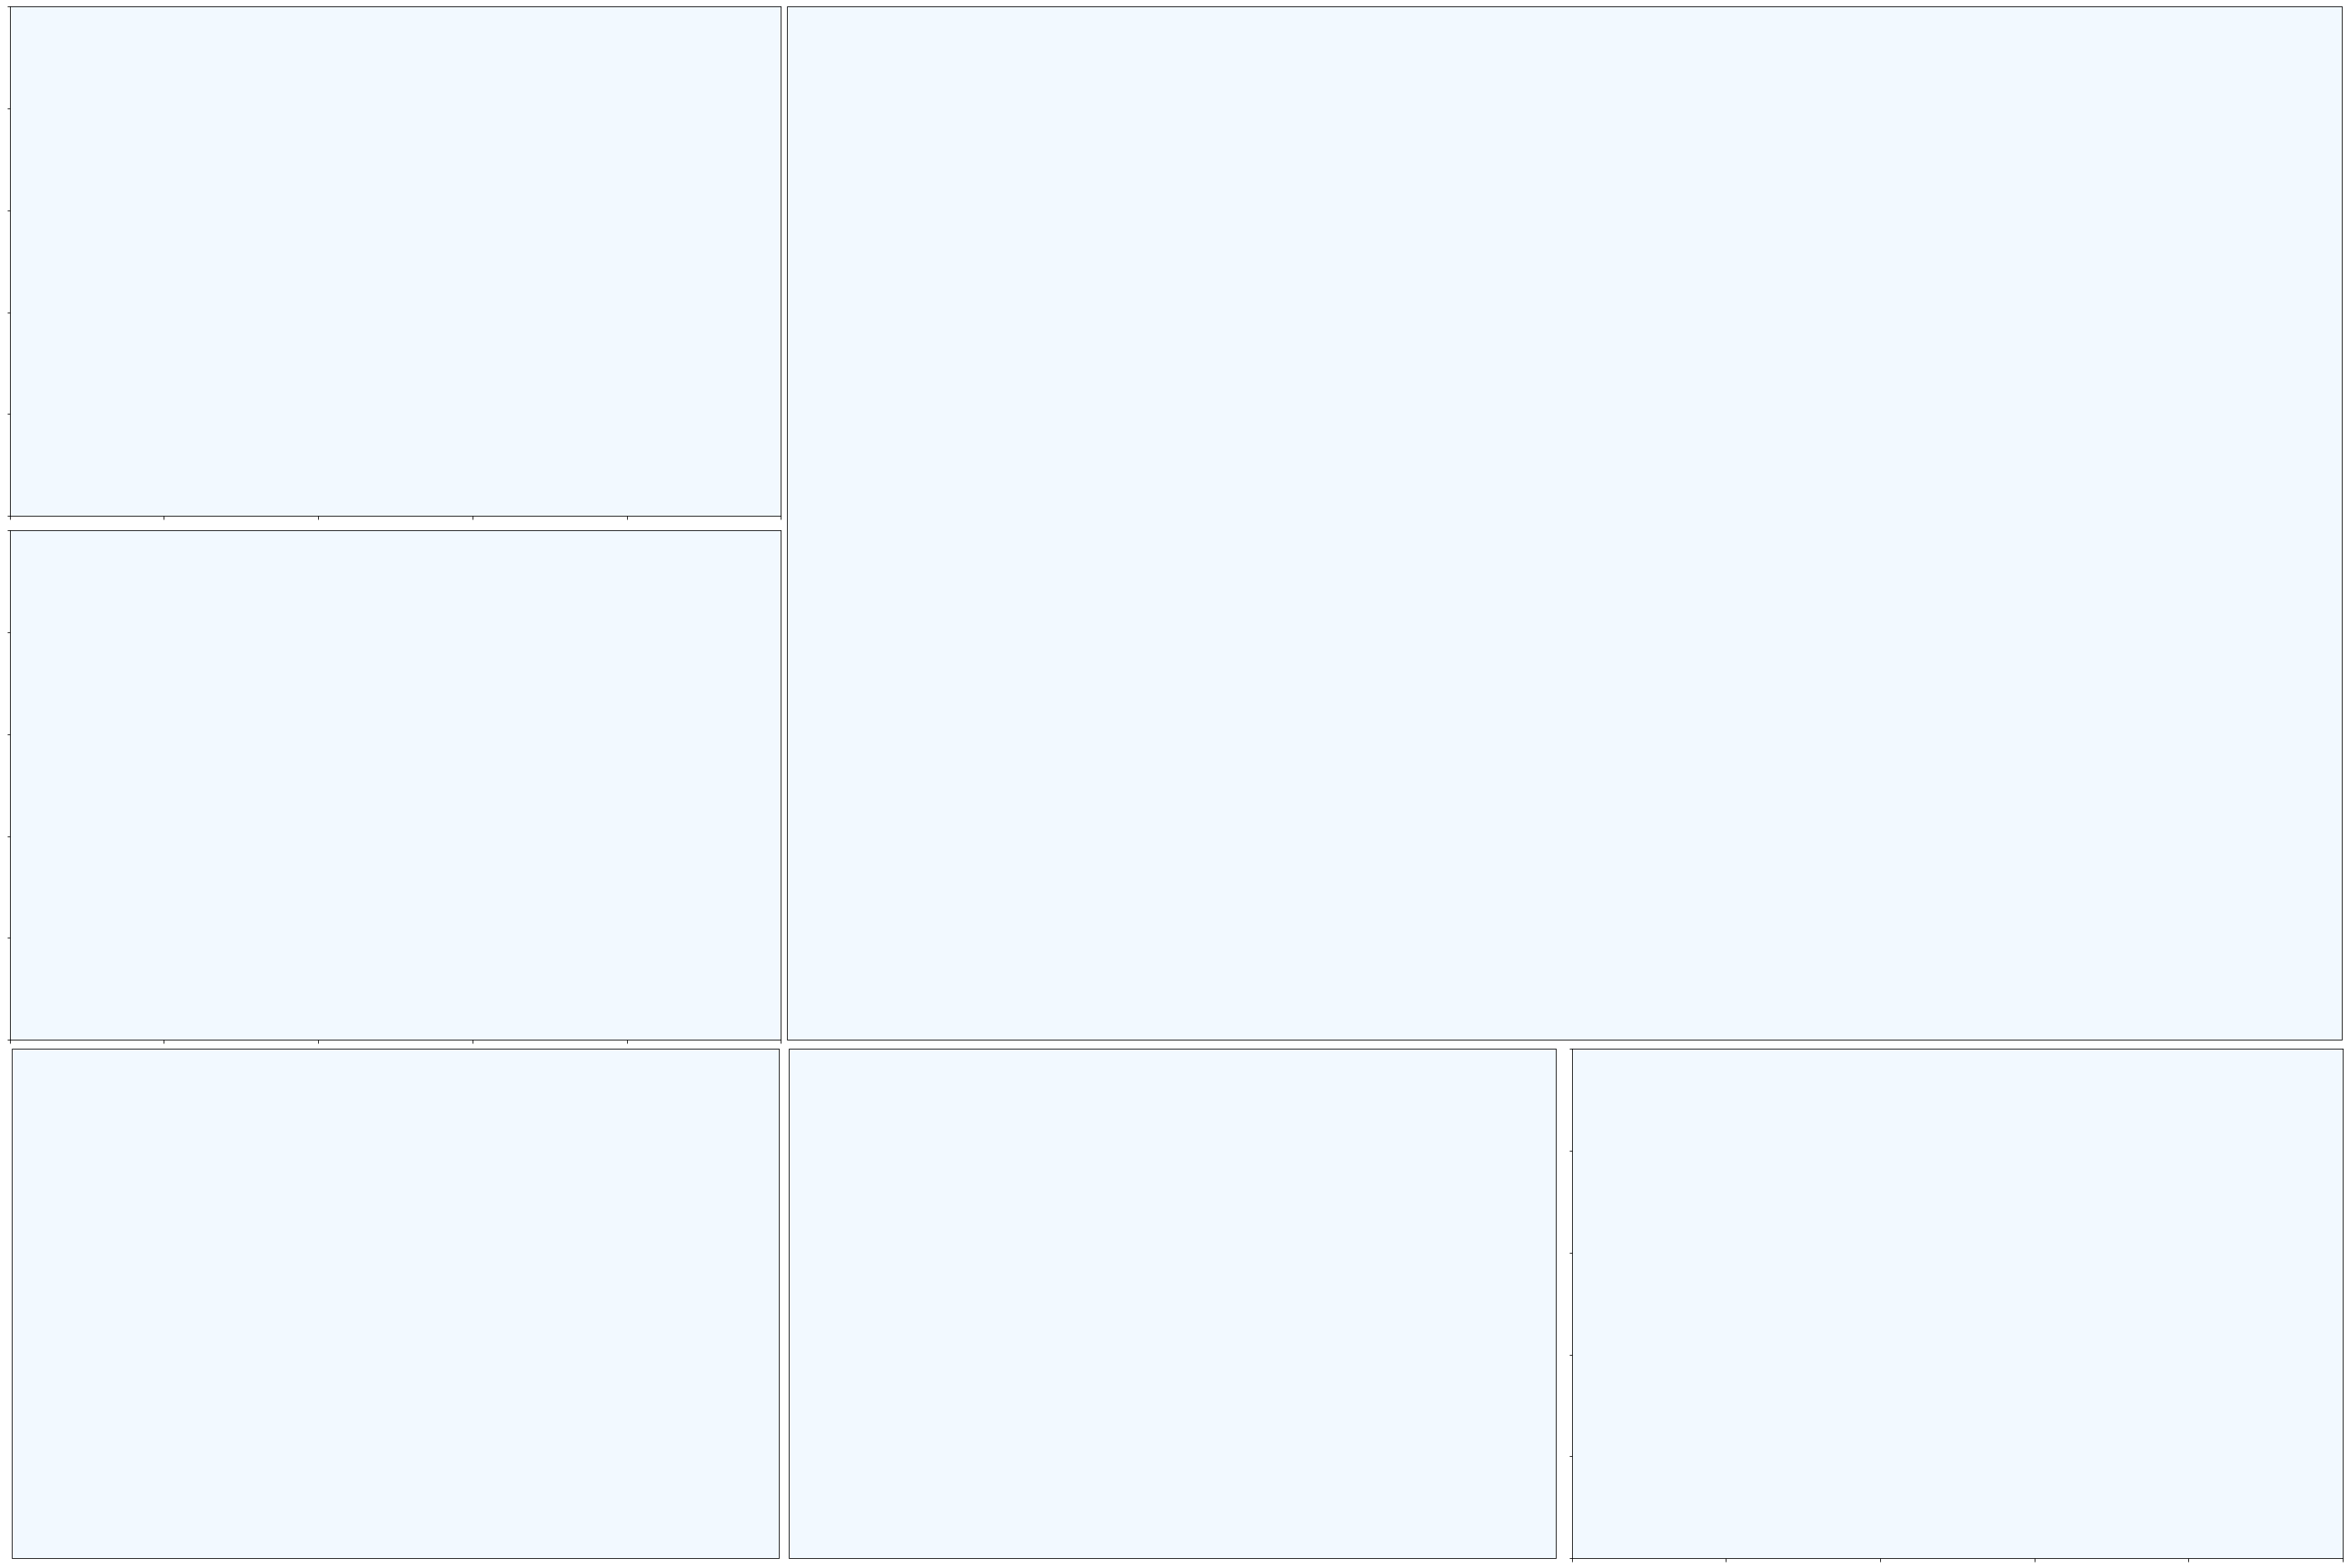

In [8]:
## computations
def process_layout():
    
    ## import needed objects
    from matplotlib.pyplot import figure
    from matplotlib.gridspec import GridSpec
    from matplotlib.colors import hsv_to_rgb
    
    ## generate segmented plotting space
    dashboard_figure = figure(figsize = (36, 24), constrained_layout = True)
    fig_grid  = GridSpec(3, 3, figure = dashboard_figure, wspace = 0.00,
                         hspace = 0.00)
    
    ## define non-map plot panels
    axis_explanation = dashboard_figure.add_subplot(fig_grid[0, 0])
    axis_progress    = dashboard_figure.add_subplot(fig_grid[1, 0])
    axis_legend_plus = dashboard_figure.add_subplot(fig_grid[2, 2])
    
    ## define map plot panels
    axis_travels = dashboard_figure.add_subplot(fig_grid[0:2, 1:3],
        projection = map_projection)
    axis_routes = dashboard_figure.add_subplot(fig_grid[2, 1],
        projection = map_projection)
    axis_opportunity = dashboard_figure.add_subplot(fig_grid[2, 0],
        projection = map_projection)
    
    axis_travels.set_extent(map_extent)
    axis_routes.set_extent(map_extent)
    axis_opportunity.set_extent(map_extent)
    
    ## package results
    dashboard = {'travels': axis_travels,
                 'explanation': axis_explanation,
                 'routes': axis_routes,
                 'progress': axis_progress,
                 'opportunity': axis_opportunity,
                 'legend_plus': axis_legend_plus}

    for i in dashboard.keys():
        dashboard[i].tick_params(
            labelbottom = False,
            labeltop = False,
            labelleft = False,
            labelright = False
            )
        dashboard[i].set_facecolor( set_color['Background'] )
    
    ## return results
    return dashboard_figure, dashboard

dashboard_figure, dashboard = process_layout()

## display
def display_layout(the_figure):
    the_figure.savefig("C_Output/us_travels.png")
    the_figure.savefig("C_Output/us_travels.pdf")

## test
def test_layout():
    pass

# Non-Map Dashboard Panels

### Explanation: Make explanation / introduction text panel

In [9]:
## text formater helper function
def format_text(x, cl):
    
    ## prepare for text processing
    x = x.split(" ")
    even_lines = [x[0]]
    x = x[1:]
    current_line = 0
    
    ## segment text into lines <= 58 characters
    for i in x:
        if len(even_lines[current_line] + ' ' + i) > cl:
            current_line += 1
            even_lines.append(i)
        else:
            even_lines[current_line] = even_lines[current_line] + ' ' + i
    
    ## combine lines into a single string
    y = str()
    for i in even_lines:
        y = y + '\n' + i
    return y

def loop_format_text(x, char_len):
    y = ''
    for i in x:
        formatted_x = format_text(i, cl = char_len)
        y = y + formatted_x
    return y

## computations
def process_explanation(x = panel_paragraph['explanation']):
    
    ## format text into lines of <= N characters
    formatted_text = loop_format_text(x, char_len = 58)
    return formatted_text


## display
def display_explanation(explain):
    dashboard['explanation'].set_xlim(0, 12)
    dashboard['explanation'].set_ylim(0,  8)
    dashboard['explanation'].text(0.1, 0, s = explain,
                                  fontsize = set_font['M'],
                                  color = set_color['Foreground'],
                                  horizontalalignment = 'left',
                                  verticalalignment = 'bottom'
                                 )
    ## title
    dashboard['explanation'].text(11.9, 7.9, 
        s = 'My Travels in the US and Canada',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'right',
        verticalalignment = 'top'
        )
## execute
explanation = process_explanation()
display_explanation(explanation)

### Test explanation panel

In [10]:
## test
def test_explanation(ex = explanation):
    full_pass = True
    ## Has line length been regulated?    
    if( max(map(len, ex.split('\n'))) > 58 ):
        print('WARNING (test_explanation) - Some lines exceed the maximum character count')
        full_pass = False
    
    ## Does the final phrase of text match the original?
    if ex.split('\n')[-1:][0][-20:] != 'INSERT CHECK PHRASE HERE':
        print('WARNING (test_explanation) - Last line of text does not match check phrase')
        full_pass = False
        
        
    ## add manual checks to checklist
    manual_check_list.update(
        {'Does the panel have a title?':'n',
        'Does the panel have body text?':'n',
        'Does the text fit in the panel?':'n',
        'Is the panel in the top left corner?':'n'}
        )

    ## add to warning summary if needed
    if not full_pass:
        test_failures.append('test_explanation')

test_explanation()

WARNING (test_explanation) - Last line of text does not match check phrase


### Progress: Make horizontal bar charts depicting progress towards city and state travel goals

In [11]:
## computations
def process_progress(x = city_list):
    
    ## identify unvisited cities
    city_list['Unvisit'] = 1 - city_list['Visit']
    
    ## tabulate summary statistics (state_level)
    state_stats = city_list[['State', 'Photo', 'Visit', 'Unvisit']]
    state_stats = state_stats.groupby('State').max().drop(['CAN', 'PR', 'DC'])
    state_stats['Visit'] = state_stats['Visit'] - state_stats['Photo']
    state_stats['Unvisit'] = 1 - (state_stats['Visit'] + state_stats['Photo'])
    state_stats = state_stats.sum()

    ## tabulate summary statistics (city-level)
    city_list['Visit'] = city_list['Visit'] - city_list['Photo']
    city_stats = city_list[['Photo', 'Visit', 'Unvisit']].sum()
    
    ## package and return data
    y = pd.DataFrame({
        'City': city_stats,
        'State': state_stats
    })
    y = pd.melt(y, ignore_index = False).reset_index()
    y.columns = ['Status', 'Entity', 'Count']
    return y

## display
def display_progress(x, explain = panel_paragraph['progress']):
    
        ## set useful measurements
    use_measure = {'bar_start': 1.0, 'bar_height': 3 / 5}
    
    ## scale counts to match plotting coordinates
    func = lambda a: np.cumsum(a / sum(a))
    scaled_count = x[['Entity', 'Count']].groupby('Entity')
    scaled_count = scaled_count.transform(func)
    x['X'] = (scaled_count * (4.4 - use_measure['bar_start']))
    del scaled_count, func
    
    ## generate y coordinates
    x['Y'] = (x['Entity'] == 'State').astype(int)
    
    ## render horizontal barplots
    dashboard['progress'].set_xlim(0, 4.5)
    dashboard['progress'].set_ylim( 0 - (1 - use_measure['bar_height']), 2.8)
    for i in ['Unvisit', 'Visit', 'Photo']:
        dashboard['progress'].barh(
            y = x.loc[x['Status'] == i, 'Entity'],
            width = x.loc[x['Status'] == i, 'X'], 
            height = use_measure['bar_height'],
            left = use_measure['bar_start'],
            align = 'edge',
            color = set_color[i]
            )
    ## render bar count labels
    for i in range(x.shape[0]):
        if x['Count'].astype(int)[i] > 3:
            dashboard['progress'].text(
                x = x['X'][i] - 0.01 + use_measure['bar_start'],
                y = x['Y'][i] + 0.02,
                s = x['Count'].astype(int)[i],
                color = set_color['Foreground'],
                fontsize = set_font['S'],
                horizontalalignment = 'right',
                verticalalignment = 'bottom',
                bbox = dict(pad = 0.1, fc = '#FFFFFF88', ec = '#FFFFFF00',
                            boxstyle = 'Round', mutation_aspect = 1.1)
                )
    ## render legend
    dashboard['progress'].legend(
        labels = ['Unvisited', 'Visited', 'Photographed'],
        fontsize = set_font['S'],
        loc = 'upper left'
        )
    ## render title and explanation
    dashboard['progress'].text(4.5 - 0.1 * (3/8), 2.8 - 0.1 * (3/8), 
        s = 'Progress Toward Goal',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'right',
        verticalalignment = 'top'
        )
    dashboard['progress'].text(0.05, 3.0 - 0.25 - 0.1, 
        s = loop_format_text(panel_paragraph['progress'], 50),
        fontsize = set_font['M'],
        color = set_color['Foreground'],
        horizontalalignment = 'left',
        verticalalignment = 'top'
        )
    dashboard['progress'].text(
        x = use_measure['bar_start'],
        y = 0.0 + use_measure['bar_height'] / 2,
        s = "PLACEHOLD \nTEXT ",
        verticalalignment = 'center',
        horizontalalignment = 'right',
        fontsize = set_font['M']
    )

## test
def test_progress(x):
    pass

## execute
progress = process_progress()
display_progress(progress)

### Legend Plus: Display table with legend and other information about planned routes

In [12]:
## computations
class LegendTable:
    
    def __init__(self, pd_df):
        x = pd_df['drive_mileage'].values
        x = np.ceil(x / 25) * 25
        pd_df.loc[:, 'drive_mileage'] = x.astype(int)
        del x
        self.table = [list(pd_df.iloc[i]) for i in range(pd_df.shape[0])]
        self.index = pd_df.index
        self.columns = pd_df.columns
        
    def __str__(self):
        print('Columns:')
        for i in self.columns:
            print(i, end = ' ')
        print('\n----')
        for i in self.table:
            print(i)
        return ''


def process_legend_plus(rl = route_list):
    rl = rl[['route', 'pre_travel', 'drive_mileage', 'trip_days',
             'best_temp_1', 'best_temp_2']]
    return LegendTable(rl)
    
## display
def display_legend_plus(rl):
    
    ## set parameters for plot
    dashboard['legend_plus'].set_xlim(0, 12)
    dashboard['legend_plus'].set_ylim(0, 8)
    
    ## render table
    y = dashboard['legend_plus'].table(
        cellText = rl.table,
        rowLabels = None,
        colLabels = rl.columns,
        edges = 'open',
        loc = 'lower right',
        colLoc = 'right'
        )
    y.auto_set_font_size(False)
    y.set_fontsize(set_font['S'])
    y.scale(0.8, 2.5)

    ## title
    dashboard['legend_plus'].text(11.9, 7.9, 
        s = 'Planned Routes Information Table',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'right',
        verticalalignment = 'top'
        )
    
    ## color key
    dashboard['legend_plus'].scatter(
        [0.1 + 1.00 for i in range(15)],
        [0.43 * (i + 1) for i in range(15)],
        marker = 's',
        s = 60,
        c = set_color['Foreground']
        )
    
    
## test
def test_legend_plus():
    pass

## execute
legend_plus = process_legend_plus()
display_legend_plus(legend_plus)
display_layout(dashboard_figure)

/var/folders/xk/rmkl6dh17jl6zqhzl0ky4b_w0000gp/T/ipykernel_7097/4008170268.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df.loc[:, 'drive_mileage'] = x.astype(int)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


# Map Dashboard Panels

### Map: Make the background map underlying the map panels

In [13]:
## computations (not needed so far; keeping stub here just in case)
def process_map():
    pass

## display
def display_map():
    
    ## add coastlines and state borders to plot
    for i in ['travels', 'routes']:
        dashboard[i].add_feature(ct.feature.LAND,
                                 lw = 1,
                                 edgecolor = (0, 0, 0, 0),
                                 facecolor = set_color['Land']
                                )
        dashboard[i].add_feature(ct.feature.STATES,
                                    lw = 1,
                                    edgecolor = set_color['Border']
                                   )
        dashboard[i].add_feature(ct.feature.COASTLINE,
                                    lw = 1,
                                    edgecolor = set_color['Coast']
                                   )
        dashboard[i].add_feature(ct.feature.LAKES,
                                    lw = 1,
                                    edgecolor = set_color['Border'],
                                    facecolor = set_color['Background']
                                   )
    
## test
def test_map():
    pass

## execute
display_map()

### Routes: Map planned routes

In [14]:
## computations (just a stub for now
def process_routes(rt = routes):
    return rt

## display
def display_routes(rt):
    for i in rt.keys():
        dashboard['routes'].add_geometries(
            rt[i],
            crs = ct.crs.PlateCarree(),
            edgecolor = set_color['Photo'],
            facecolor = (0,0,0,0),
            linewidth = 2
        )
    dashboard['routes'].text(-62, 50, 
        s = 'Map of Planned Routes',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'right',
        verticalalignment = 'top',
        transform = ct.crs.PlateCarree()
        )

## test
def test_routes():
    pass

routes = process_routes()
display_routes(routes)

### Travels: Map past travels

In [15]:
## computations
def process_travels(x = travels):
    return process_routes(x)

## display
def display_travels(rt):
    for i in rt.keys():
        dashboard['travels'].add_geometries(
            rt[i],
            crs = ct.crs.PlateCarree(),
            edgecolor = set_color['Photo'],
            facecolor = (0,0,0,0),
            linewidth = 2
        )
    dashboard['travels'].text(-62, 50, 
        s = 'My Travels So Far',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'right',
        verticalalignment = 'top',
        transform = ct.crs.PlateCarree()
        )

## test
def test_travels():
    pass

travels = process_travels()
display_travels(travels)

### Opportunity: Map geographic areas where visit will contribute to goals
+ Kernel density heat map with plasma color scaling

In [16]:
set_op_color = [
    set_color['Land'],
    hsv(6/12, 0.1, 0.9),
    hsv(6/12, 0.2, 0.7),
    hsv(6/12, 0.3, 0.5),
    hsv(6/12, 0.4, 0.3)
  ]

## computations
def process_opportunity(cl = city_list):
    
    ## remove PR, HI, AK from data
    cl = cl[~cl.State.isin(['AK', 'HI', 'PR'])]
    
    ## trim excess precision
    cl = cl.round(2)
    
    ## generate a meshgrid
    us_mesh = np.meshgrid(
        np.arange(cl['lon'].min()-1, cl['lon'].max()+1, 1.0),
        np.arange(cl['lat'].min()-1, cl['lat'].max()+1, 1.0)
        )
    for i in range(2):
        us_mesh[i] = us_mesh[i].reshape(us_mesh[i].size)
    us_mesh = pd.DataFrame(us_mesh).T
    us_mesh.columns = ['lon', 'lat']
    
    ## generate row indices for the mesh grid
    us_mesh['lon_ind'] = pd.Categorical(us_mesh.lon).codes
    us_mesh['lat_ind'] = pd.Categorical(us_mesh.lat).codes
    us_mesh = us_mesh.set_index(['lon_ind', 'lat_ind'])
    
    ## define function to calculate distances
    def calculate_distance(x1, x2):
        ## make an empty matrix to hold results
        x1n = x1.shape[0]
        x2n = x2.shape[0]
        dist = np.zeros((x1n, x2n)).astype(int)
        
        ## calculate distance for each point
        for i in range(x1n):
            for j in range(x2n):
                dist[i, j] = int(earth_distance(
                    tuple(x1[['lat', 'lon']].iloc[i]),
                    tuple(x2[['lat', 'lon']].iloc[j])
                    ).mi)
                dist[i, j] = int(dist[i, j])
        return dist
    
    ## calculate proximity for each mesh point (retrieve from disk if possible)
    try:
        dist = np.load('B_Process/dist.npy')
    except:
        dist = np.zeros((1,))

    if dist.shape == (cl.shape[0], us_mesh.shape[0]):
        pass
    else:
        dist = calculate_distance(cl, us_mesh)
        np.save('B_Process/dist.npy', dist)
    
    ## convert distance to proximity
    dist = dist < 100
    dist = dist.astype(int)
    
    ## calculate opportunity score for each point; package for return
    us_mesh['Score'] = np.matmul(dist.T, cl.Score.values)
    us_mesh = us_mesh.reset_index()
    new_shape = (max(us_mesh.lat_ind) + 1, max(us_mesh.lon_ind) + 1)
    us_mesh = [
        us_mesh.lon.values.reshape(new_shape),
        us_mesh.lat.values.reshape(new_shape),
        us_mesh.Score.values.reshape(new_shape)
    ]
    return us_mesh
    
## display
def display_opportunity(op):

    ## determine color breaks
    color_breaks = np.zeros(6,)
    color_breaks[0:4] = (0, 0.9, 1.9, 2.9)
    color_breaks[5]   = op[2].max() + 0.1
    color_breaks[4]   = (color_breaks[5] + color_breaks[3]) / 2
    color_breaks = np.unique(color_breaks)

    ## generate contours
    dashboard['opportunity'].contourf(
        np.unique(op[0]),
        np.unique(op[1]),
        op[2],
        levels = color_breaks,
        colors = set_op_color,
        transform = ct.crs.PlateCarree()
        )


    ## mask contours for non-land
    dashboard['opportunity'].add_feature(ct.feature.LAND,
                                    lw = 1,
                                    color = set_color['Land']
                                   )
    dashboard['opportunity'].add_feature(ct.feature.OCEAN,
                                    lw = 1,
                                    facecolor = set_color['Background'],
                                    edgecolor = set_color['Coast'],
                                    zorder = 98
                                   )
    dashboard['opportunity'].add_feature(ct.feature.LAKES,
                                    lw = 1,
                                    facecolor = set_color['Background'],
                                    edgecolor = set_color['Border']
                                   )
    dashboard['opportunity'].add_feature(ct.feature.STATES,
                                    lw = 1,
                                    edgecolor = set_color['Border']
                                   )
    
    dashboard['opportunity'].text(-62, 50, 
        s = 'Opportunities For Goal Progress',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'right',
        verticalalignment = 'top',
        transform = ct.crs.PlateCarree(),
        zorder = 99
        )
    
## test
def test_opportunity():
    pass


## execute
opportunity = process_opportunity()
display_opportunity(opportunity)

# Finalization Tasks

### Finish Rendering Visualization

In [17]:
display_layout(dashboard_figure)

### final testing

In [29]:
## Report problems found during automated testing

if len(test_failures) > 0:
    print('== Manual quality testing: ========')
    print('\nThese automated tests found potential problems:')
    for i in test_failures:
        print("  " + i)
        
## Conduct manual testing
def manual_testing(proceed = True):
    if proceed:
        print('\n')
        print('== Manual quality check list: ========')
        for i in manual_check_list.keys():
            manual_check_list[i] = input(i)
        print('\nThese manual checks found potential problems:')
        for i in manual_check_list.keys():
            if manual_check_list[i] == 'n':
                print('  ' + i)

manual_testing()

== Manual quality testing: ========

These automated tests found potential problems:
  test_texts
  test_explanation


== Manual quality check list: ========


Does the panel have a title? n
Does the panel have body text? y
Does the text fit in the panel? n
Is the panel in the top left corner? y



These manual checks found potential problems:
  Does the panel have a title?
  Does the text fit in the panel?


### REMINDERS & NOTES

In [18]:
## TODO: Add opportunity scores to legend plus table
time_check('Z')

Time Check: Point Z
2022-02-22 14:38:32.317957

These test functions detected problems:
  test_texts
  test_explanation
